# Anomaly Detection Demo
Hi there! Welcome!  

This notebook will use a trained model to detect power rail anomalies on infrared images.

Please only infer images exported using Rainbow3 Palette in ResearchIR software.

If required modules are installed properly, detections will be visualized at the bottom of the page.

This is just a demo. Please do not use it to infer more than 50 images each time, it will take very long time.

Follow the GUI notebooks for full video inference.

Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Object detection imports
Here are the imports from the object detection module.

In [2]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [3]:
#Location of the inference model.
PATH_TO_CKPT = 'frozen_graphs/nb_117neg_fr.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'anomaly_label_map.pbtxt')

# number of classes to be detected, we only have 1 class which is anomlay
NUM_CLASSES = 1

## Test Images Path

In [4]:
# If you want to test the code with other images, just add images in a subfolder in test_images and change the path here
PATH_TO_TEST_IMAGES_DIR = 'test_images'
sub_folder = 'sb_report'

TEST_IMAGE_PATHS = [];
for file in os.listdir(PATH_TO_TEST_IMAGES_DIR+'/'+sub_folder):
    if file.endswith(".jpg"):
        TEST_IMAGE_PATHS.append(os.path.join(PATH_TO_TEST_IMAGES_DIR, sub_folder, file))

# Size, in inches, of the output images.
IMAGE_SIZE = (8, 5)

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

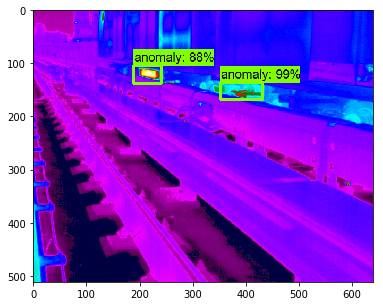

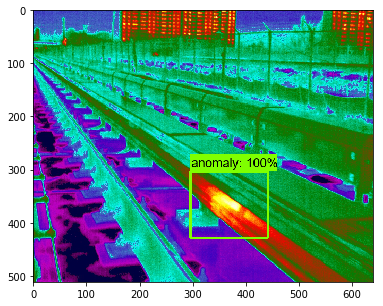

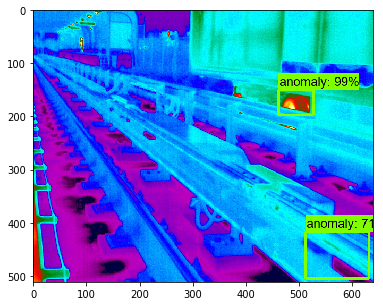

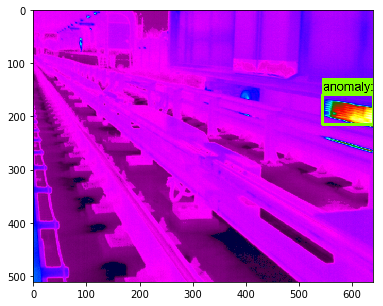

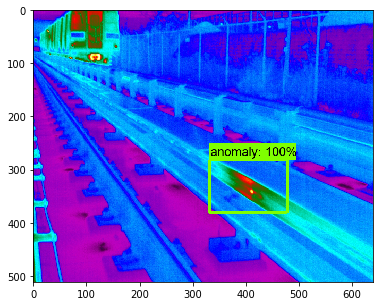

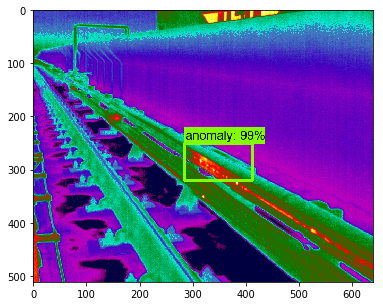

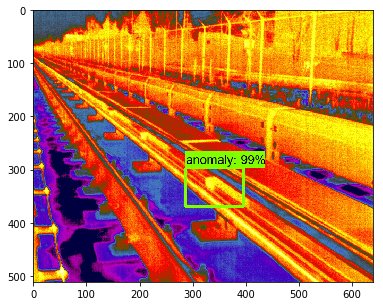

In [9]:
dict_list = [];
for image_path in TEST_IMAGE_PATHS:
  image_name = image_path.split('\\')[-1]
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  #dict_list.append(output_dict['detection_scores']);
  dict_list.append(output_dict);
  # Visualization of the results of a detection.
  if max(output_dict['detection_scores'])>0.5:
        vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks'),
              use_normalized_coordinates=True,
              line_thickness=5)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

In [10]:
# example of inference result dictionary
output_dict

{'num_detections': 5,
 'detection_boxes': array([[0.55591214, 0.40743133, 0.6999661 , 0.5826023 ],
        [0.40481448, 0.2693878 , 0.50901276, 0.36663902],
        [0.        , 0.45126477, 0.33568257, 0.9613121 ],
        [0.701589  , 0.58400744, 0.97743976, 0.9024621 ],
        [0.05381392, 0.6842044 , 0.49373853, 0.9681077 ]], dtype=float32),
 'detection_scores': array([6.4805478e-02, 2.2859855e-03, 1.4127510e-08, 6.6806987e-09,
        6.3665047e-09], dtype=float32),
 'detection_classes': array([1, 1, 1, 1, 1], dtype=uint8)}

In [11]:
#ratio of anomaly found in test images, score threshold =0.5
count =0;
for i in dict_list:
    scores = i['detection_scores'];
    boxes = i['detection_boxes'];
    if max(scores)>0.5:
        count+=1;
count/len(dict_list)

0.7777777777777778